In [6]:
!pip install deepface facenet-pytorch

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 70.0 

## Check the image format , Resolution and Blur

In [7]:
import cv2
import os
from PIL import Image
from google.colab import files


In [8]:

def validate_input_image(image_path: str, min_width=512, min_height=512, blur_threshold=100.0):
    # --- Check file exists ---
    if not os.path.exists(image_path):
        return "File not found"

    # --- Check file format ---
    valid_formats = (".jpeg", ".png")
    ext = os.path.splitext(image_path)[-1].lower()
    if ext not in valid_formats:
        return "Invalid format (Only JPG or PNG allowed)"

    # --- Open and check resolution ---
    try:
        img = Image.open(image_path)
    except Exception:
        return "Cannot open image"

    width, height = img.size
    if width < min_width or height < min_height:
        return f"Low resolution ({width}x{height}) — minimum {min_width}x{min_height} required"

    # --- Check for blur (clarity) using variance of Laplacian ---
    image_cv = cv2.imread(image_path)
    gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    if laplacian_var < blur_threshold:
        return f"Image is blurry (variance={laplacian_var:.2f} < {blur_threshold})"

    return "Image Successfully passed validation!"


# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Validate the image
result = validate_input_image(image_path)
print(result)

Saving Screenshot 2025-10-31 214204.png to Screenshot 2025-10-31 214204 (1).png
Image Successfully passed validation!


## Detect the face of the person

In [9]:
from deepface import DeepFace
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

Detecting faces...
Saved cropped face to: faces_output/face_1.jpg


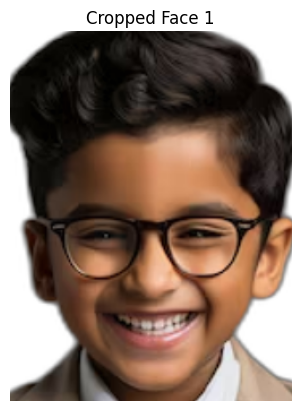

Done — all faces cropped with slightly expanded area!


In [10]:
img_path = image_path

# Step 4: Create output folder
os.makedirs("faces_output", exist_ok=True)

# Step 5: Detect faces using RetinaFace (best accuracy)
print("Detecting faces...")
detections = DeepFace.extract_faces(img_path=img_path, detector_backend='retinaface', enforce_detection=True)

if len(detections) == 0:
    raise ValueError("No face detected! Please upload a clearer image.")

# Step 6: Load original image
img = cv2.imread(img_path)
img_h, img_w = img.shape[:2]

# Step 7: Loop through detected faces and crop with padding
for i, det in enumerate(detections):
    region = det["facial_area"]

    x, y, w, h = region["x"], region["y"], region["w"], region["h"]

    # Add padding around face
    pad_top = int(h * 0.40)
    pad_side = int(w * 0.20)
    pad_bottom = int(h * 0.05)

    x1 = max(0, x - pad_side)
    y1 = max(0, y - pad_top)
    x2 = min(img_w, x + w + pad_side)
    y2 = min(img_h, y + h + pad_bottom)

    # Crop region
    face_crop = img[y1:y2, x1:x2]

    # Save cropped face
    out_path = f"faces_output/face_{i+1}.jpg"
    cv2.imwrite(out_path, face_crop)
    print(f"Saved cropped face to: {out_path}")

    # Optional: Display the cropped face inline
    face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
    plt.imshow(face_rgb)
    plt.axis("off")
    plt.title(f"Cropped Face {i+1}")
    plt.show()

print("Done — all faces cropped with slightly expanded area!")


## Detect the Age Emotion And Gender of Person

In [11]:
from deepface import DeepFace
import numpy as np
from collections import Counter


In [12]:
# Path to cropped face image
img = face_rgb

# Detector backends for robust evaluation
backends = ["retinaface", "mtcnn", "ssd"]

ages = []
genders = []
emotions = []

print("\nStarting multi-backend face analysis...\n")

for backend in backends:
    try:
        print(f"Using detector backend: {backend}")

        # Analyze face attributes using the selected backend
        result = DeepFace.analyze(
            img_path=img,
            actions=['age', 'gender', 'emotion'],
            detector_backend=backend,
            enforce_detection=False
        )[0]

        age = result['age']
        gender = result['dominant_gender']
        emotion = result['dominant_emotion']

        ages.append(age)
        genders.append(gender)
        emotions.append(emotion)

        print(f"   Age: {age}")
        print(f"   Gender: {gender}")
        print(f"   Emotion: {emotion}")
        print("-" * 50)

    except Exception as e:
        print(f"{backend} failed: {e}")
        print("-" * 50)

# Summary statistics
print("\nFinal Summary")
print("=" * 50)

if ages:
    mean_age = round(np.mean(ages), 1)
    print(f"Average estimated age: {mean_age} years")
else:
    print("No valid age predictions found.")

if genders:
    gender_counts = Counter(genders)
    most_common_gender, gender_count = gender_counts.most_common(1)[0]
    print(f"Most common gender: {most_common_gender} ({gender_count} detections)")
else:
    print("No gender predictions found.")

if emotions:
    emotion_counts = Counter(emotions)
    most_common_emotion, emotion_count = emotion_counts.most_common(1)[0]
    print(f"Most common emotion: {most_common_emotion} ({emotion_count} detections)")
else:
    print("No emotion predictions found.")

print("=" * 50)


Starting multi-backend face analysis...

Using detector backend: retinaface


Action: emotion: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


   Age: 21
   Gender: Man
   Emotion: happy
--------------------------------------------------
Using detector backend: mtcnn


Action: emotion: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


   Age: 25
   Gender: Man
   Emotion: happy
--------------------------------------------------
Using detector backend: ssd


Action: emotion: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

   Age: 22
   Gender: Man
   Emotion: happy
--------------------------------------------------

Final Summary
Average estimated age: 22.7 years
Most common gender: Man (3 detections)
Most common emotion: happy (3 detections)


## Convert Image into 3D Diseny Image

In [14]:
!pip install diffusers==0.27.2 transformers==4.40.2 accelerate==0.26.1 safetensors==0.4.3 huggingface_hub==0.23.2

In [15]:
!pip install accelerate==0.26.1

In [1]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import os

In [21]:
!pip install diffusers==0.21.4 accelerate==0.24.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.27.2
    Uninstalling diffusers-0.27.2:
      Successfully uninstalled diffusers-0.27.2
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.26.1
    Uninstalling accelerate-0.26.1:
      Successfully uninstalled accelerate-0.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.17.1 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.23.2 which is incompatible.


Loading Disney 3D model....
   Trying nitrosocke/mo-di-diffusion...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--nitrosocke--mo-di-diffusion/snapshots/e3106d24aa8c37bf856257daea2ae789eabc4d70/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--nitrosocke--mo-di-diffusion/snapshots/e3106d24aa8c37bf856257daea2ae789eabc4d70/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--nitrosocke--mo-di-diffusion/snapshots/e3106d24aa8c37bf856257daea2ae789eabc4d70/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--nitrosocke--mo-di-diffusion/snapshots/e3106d24aa8c37bf856257daea2ae789eabc4d70/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Model loaded successfully: nitrosocke/mo-di-diffusion
Loading image: /content/Screenshot 2025-10-31 222525.png
Generating subtle Disney avatar...
 Params: strength=0.4, guidance=8.0, steps=45


  0%|          | 0/18 [00:00<?, ?it/s]

Subtle Disney avatar saved: disney_subtle.png


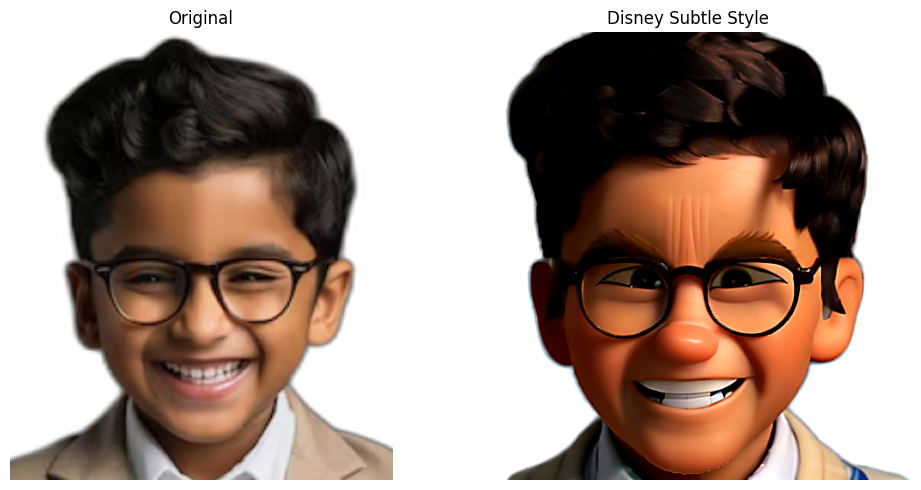

In [3]:
class Disney3DAvatarGenerator:
    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = torch.device(device)
        self.dtype = torch.float16 if self.device.type == "cuda" else torch.float32
        self.pipe = None

    def load_model(self):
        """Load Disney-style Stable Diffusion model."""
        if self.pipe is not None:
            return

        print("Loading Disney 3D model....")

        models = [
            "nitrosocke/mo-di-diffusion",
            "prompthero/openjourney-v4",
            "stablediffusionapi/disney-pixar-cartoon",
            "runwayml/stable-diffusion-v1-5"
        ]

        for model_id in models:
            try:
                print(f"   Trying {model_id}...")
                self.pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
                    model_id,
                    torch_dtype=self.dtype,
                    safety_checker=None,
                    requires_safety_checker=False
                ).to(self.device)

                self.pipe.enable_attention_slicing()
                print(f"Model loaded successfully: {model_id}")
                return
            except Exception as e:
                print(f"Failed: {e}")
        raise RuntimeError("Could not load any Disney-style model.")

    def preprocess_image(self, image: Image.Image) -> Image.Image:
        """Prepare input image."""
        image = ImageEnhance.Sharpness(image).enhance(1.3)
        image = ImageEnhance.Contrast(image).enhance(1.15)

        image.thumbnail((768, 768), Image.Resampling.LANCZOS)
        w, h = image.size
        size = min(w, h)
        image = image.crop(((w - size) // 2, (h - size) // 2, (w + size) // 2, (h + size) // 2))
        return image.resize((512, 512), Image.Resampling.LANCZOS)

    def postprocess_avatar(self, avatar: Image.Image) -> Image.Image:
        """Enhance generated avatar."""
        avatar = ImageEnhance.Color(avatar).enhance(1.2)
        avatar = ImageEnhance.Contrast(avatar).enhance(1.1)
        avatar = avatar.filter(ImageFilter.UnsharpMask(radius=1.5, percent=150, threshold=3))
        return avatar

    def generate_subtle_disney_avatar(self, input_image_path: str, output_image_path: str = "disney_subtle.png"):
        """Generate subtle Disney 3D avatar (strength=0.4, guidance=8.0, steps=45)."""
        if not os.path.exists(input_image_path):
            raise FileNotFoundError(f"Input image not found: {input_image_path}")

        self.load_model()

        print(f"Loading image: {input_image_path}")
        input_image = Image.open(input_image_path).convert("RGB")
        processed = self.preprocess_image(input_image)

        positive_prompt = (
            "3D Disney Pixar character, high quality 3D render, "
            "animation studio style, smooth features, expressive eyes, "
            "friendly face, bright lighting, vibrant colors, detailed textures"
        )

        negative_prompt = (
            "realistic, photograph, photorealistic, blurry, deformed, bad anatomy, "
            "grainy, watermark, text, signature"
        )

        print("Generating subtle Disney avatar...")
        print(" Params: strength=0.4, guidance=8.0, steps=45")

        with torch.no_grad():
            generator = torch.Generator(device=self.device).manual_seed(42)
            result = self.pipe(
                prompt=positive_prompt,
                negative_prompt=negative_prompt,
                image=processed,
                strength=0.4,
                guidance_scale=8.0,
                num_inference_steps=45,
                generator=generator
            ).images[0]

        result = self.postprocess_avatar(result)
        result.save(output_image_path, quality=95)
        print(f"Subtle Disney avatar saved: {output_image_path}")

        # Show input and output side by side
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(input_image)
        axs[0].set_title("Original")
        axs[0].axis("off")

        axs[1].imshow(result)
        axs[1].set_title("Disney Subtle Style")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()


input_image_path = face_rgb
generator = Disney3DAvatarGenerator()
generator.generate_subtle_disney_avatar(input_image_path)


## Replace the face with templete person face.

In [4]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 101.5 MB/s eta 0:00:00


In [ ]:
import onnx
onnx_model_path = "/content/inswapper_128 (1).onnx"
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print("✅ Model is valid ONNX")

✅ Model is valid ONNX


In [7]:
!pip install mediapipe insightface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━

In [2]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00


In [3]:
import os
import cv2
import copy
import insightface
import onnxruntime
import numpy as np
from PIL import Image
from typing import List, Union

def getFaceSwapModel(model_path: str):
    model = insightface.model_zoo.get_model(model_path)
    return model

def getFaceAnalyser(providers, det_size=(320, 320)):
    face_analyser = insightface.app.FaceAnalysis(name="buffalo_l", root="./checkpoints", providers=providers)
    face_analyser.prepare(ctx_id=0, det_size=det_size)
    return face_analyser

def get_many_faces(face_analyser, frame: np.ndarray):
    faces = face_analyser.get(frame)
    return sorted(faces, key=lambda x: x.bbox[0]) if faces else None

def swap_face(face_swapper, source_face, target_face, frame):
    return face_swapper.get(frame, target_face, source_face, paste_back=True)

def face_swapper(source_image_path: Union[str, List[str]],
                 target_image_path: str,
                 model_path: str ,
                 output_path: str = "result.png",
                 restore_faces: bool = False):

    # Load providers and models
    providers = onnxruntime.get_available_providers()
    face_analyser = getFaceAnalyser(providers)
    face_swapper_model = getFaceSwapModel(model_path)

    # Load images
    if isinstance(source_image_path, str):
        source_image_path = [source_image_path]

    source_imgs = [cv2.cvtColor(np.array(Image.open(img)), cv2.COLOR_RGB2BGR)
                   for img in source_image_path]
    target_img = cv2.cvtColor(np.array(Image.open(target_image_path)), cv2.COLOR_RGB2BGR)

    # Detect faces
    target_faces = get_many_faces(face_analyser, target_img)
    if target_faces is None:
        raise ValueError("No target faces found!")

    temp_frame = copy.deepcopy(target_img)

    if len(source_imgs) == 1:
        source_faces = get_many_faces(face_analyser, source_imgs[0])
        if source_faces is None:
            raise ValueError("No source faces found!")
        for i, target_face in enumerate(target_faces):
            temp_frame = swap_face(face_swapper_model, source_faces[0], target_face, temp_frame)
    else:
        if len(source_imgs) != len(target_faces):
            raise ValueError("Number of source images must match number of target faces!")
        for i in range(len(target_faces)):
            source_faces = get_many_faces(face_analyser, source_imgs[i])
            if source_faces is None:
                raise ValueError(f"No face found in source image {i}")
            temp_frame = swap_face(face_swapper_model, source_faces[0], target_faces[i], temp_frame)

    # Convert result to PIL and save
    result_image = Image.fromarray(cv2.cvtColor(temp_frame, cv2.COLOR_BGR2RGB))
    result_image.save(output_path)
    print(f"Face swap completed and saved to {output_path}")

    return result_image

Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'AzureExecutionProvider': {}}
find model: ./checkpoints/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'AzureExecutionProvider': {}}
find model: ./checkpoints/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'AzureExecutionProvider': {}}
find model: ./checkpoints/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'AzureExecutionProvider': {}}
find model: ./checkpoints/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['AzureExec

/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
inswapper-shape: [1, 3, 128, 128]


/usr/local/lib/python3.12/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Face swap completed and saved to /content/output.png


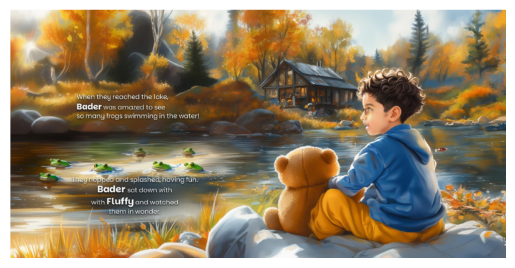

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# Run your swap function
result = face_swapper(
    source_image_path="/content/3D_designy_image.png",
    target_image_path="/content/templete.png",
    model_path="/content/inswapper_128.onnx",
    output_path="/content/output.png"
)

# Load the saved output
img = Image.open("/content/output.png")

# Display inline
plt.imshow(img)
plt.axis("off")
plt.show()

## Tamplete face not replace perfect it should happened when i use multimodel(openai, Together ai model) API

## After convert the image into 3d disney image using difussion model  ------ Then i use Subtle because it give better.

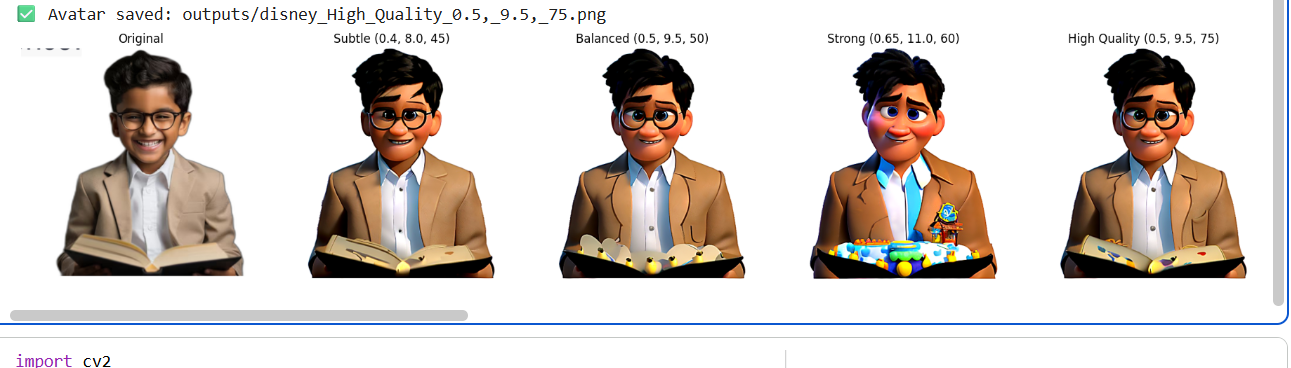

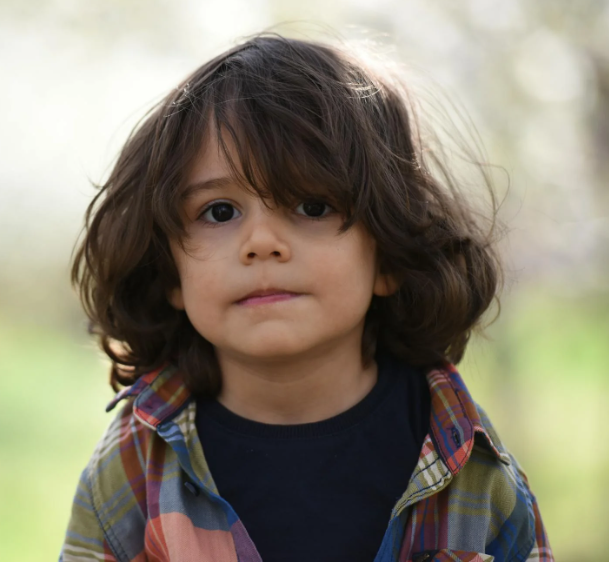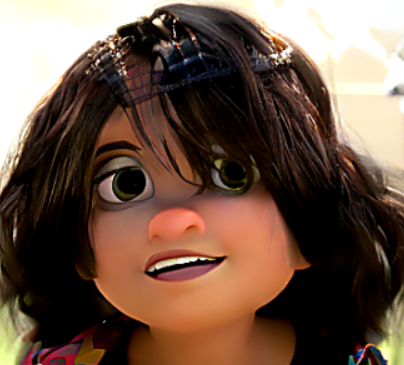